In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import numpy as np
import cv2 as cv
import datetime

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)


X_train = X_train.astype('float32') # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255 # normalize 
X_test /= 255

In [5]:
# one-hot format classes

nb_classes = 10 # number of unique digits

y_train = tf.one_hot(y_train, nb_classes)
y_test = tf.one_hot(y_test, nb_classes)

y_test.shape
y_train.shape

2022-07-10 22:00:37.383275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 22:00:37.387495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karol/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-07-10 22:00:37.387986: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping re

TensorShape([60000, 10])

In [6]:
zoom_range=(1,2) # define zoom range
# Create ImageDataGenerator training instance with data augmentation
train_datagen = ImageDataGenerator(width_shift_range=(0.08, 2), # shift the image width ways
                                   height_shift_range=(0.08, 2) ) # shift the image height ways

valid_datagen = ImageDataGenerator()

In [7]:
# define number of rows & columns
num_row = 2
num_col = 8
num = num_row*num_col

TRAIN:



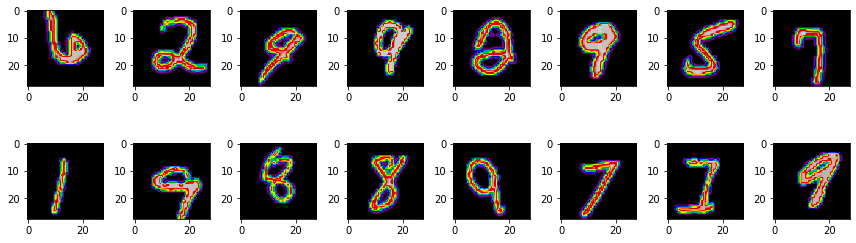

In [8]:
print('TRAIN:\n')
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for X, Y in train_datagen.flow(X_train ,y_train):
     for i in range(0, num):
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='nipy_spectral')
     break
plt.tight_layout()
plt.show()

In [9]:
train_generator = train_datagen.flow(X_train, y_train)
test_generator = valid_datagen.flow(X_test, y_test)

In [10]:
model = tf.keras.models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1))),
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')),
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')),
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                    

In [12]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator,  steps_per_epoch=60000//128, epochs=10)

Epoch 1/10
468/468 [==============================] - 24s 51ms/step - loss: 0.3209 - accuracy: 0.8944 - val_loss: 0.0523 - val_accuracy: 0.9819
Epoch 2/10
468/468 [==============================] - 24s 50ms/step - loss: 0.1039 - accuracy: 0.9697 - val_loss: 0.0557 - val_accuracy: 0.9793
Epoch 3/10
468/468 [==============================] - 24s 51ms/step - loss: 0.0775 - accuracy: 0.9770 - val_loss: 0.0586 - val_accuracy: 0.9804
Epoch 4/10
468/468 [==============================] - 23s 50ms/step - loss: 0.0654 - accuracy: 0.9804 - val_loss: 0.0307 - val_accuracy: 0.9897
Epoch 5/10
468/468 [==============================] - 23s 50ms/step - loss: 0.0555 - accuracy: 0.9816 - val_loss: 0.0380 - val_accuracy: 0.9863
Epoch 6/10
468/468 [==============================] - 23s 50ms/step - loss: 0.0486 - accuracy: 0.9852 - val_loss: 0.0272 - val_accuracy: 0.9906
Epoch 7/10
468/468 [==============================] - 23s 50ms/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.0352 - val_accuracy:

Text(0.5, 0, 'epochs')

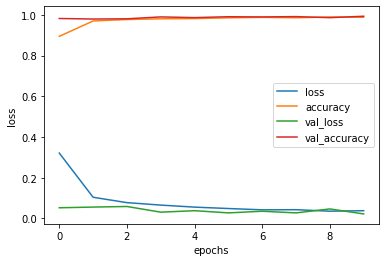

In [22]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [14]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0221 - accuracy: 0.9930


[0.022094232961535454, 0.9929999709129333]

In [23]:
model.save("model.h5")

In [24]:
def clean_box(img):
    img = img[10:82, 10:82]
    return np.array(img)

def cb(img):
    mean = img.mean()
    non_empty_columns = np.where(img.min(axis=1)<mean)[0]
    non_empty_rows = np.where(img.min(axis=1)<mean)[0]
    bb = (min(non_empty_rows)-4, max(non_empty_rows)+4, min(non_empty_columns)+4, max(non_empty_columns)+4)
    print(bb)
    return bb


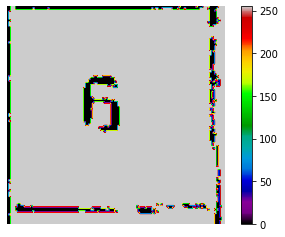

In [86]:
img = tf.io.read_file("box38.png")
img = tf.image.decode_image(img, channels=1)
plt.imshow(img, cmap="nipy_spectral")
plt.colorbar()
plt.axis(False);

(27, 67, 35, 67)


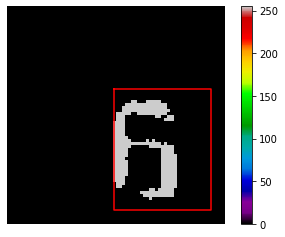

In [87]:
img = clean_box(img)
bb = cb(img)
img = cv.bitwise_not(img)


plt.imshow(img, cmap="nipy_spectral")
plt.plot([bb[2], bb[3], bb[3], bb[2], bb[2]],
         [bb[0], bb[0],bb[1], bb[1], bb[0]],
         "r-")
plt.colorbar()
plt.axis(False);

(28, 28)


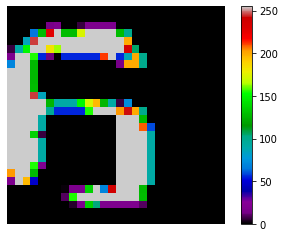

In [88]:
img = img[bb[0]:bb[1], bb[2]:bb[3]]
img = cv.resize(img, (28, 28))
plt.imshow(img, cmap="nipy_spectral")
plt.colorbar()
plt.axis(False);
print(img.shape)

In [89]:
img = tf.expand_dims(img, 0)
img.shape

TensorShape([1, 28, 28])

In [90]:
model.predict(img)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)